# Animal Classifier CNN

The following file will integrate a CNN aiming at using the `Animals-10` dataset in order to correctly classify them according to their species. Multiple different hyper parameters, transformations and models will be used through transfer learning to test out different configurations and determine which configuration leads to the best performance.

In order to maintain the code clean, the project will incorporate several helper functions, and will be modularized in the `utils` folder to keep the `main.ipynb` file as clean as possible.

Throughout the project, the structure can be seen in the outline where after setting up the foundations, the project will focus on tweaking parameters and assessing their performance through tensor board and our own manual prints.



## Data Setup

In [20]:
try:
    import torch
    import torchvision
    assert int(torch.__version__.split(".")[0]) >= 2, "torch version should be 2.+"
    assert int(torchvision.__version__.split(".")[1]) >= 15, "torchvision version should be 0.15+"
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision versions not correct. Installing correct versions.")
    !pip3 install -U torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")

from torch import nn
from torchvision import transforms
import matplotlib.pyplot as plt

try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it")
    !pip install -q torchinfo
    from torchinfo import summary

try:
    from tqdm.auto import tqdm
except:
    print(f"[INFO] Couldnt't find tqdm... installing it ")
    !pip install tqdm
    from tqdm.auto import tqdm


torch version: 2.5.1+cu124
torchvision version: 0.20.1+cu124


In [2]:
try:
    from torchinfo import summary
except ImportError:
    print("[INFO] Couldn't find torchinfo... installing it")
    !pip install -q torchinfo
    from torchinfo import summary

try:
    import splitfolders
except ImportError:
    print("[INFO] Installing splitfolders...")
    !pip install -q split-folders
    import splitfolders

try:
    from project_modules import data_setup, engine, get_data, model_builder, predictions, train, save_model, helper_functions
except ImportError:
    print("[INFO] Could not find project_modules scripts. Downloading them from GitHub.")
    !git clone https://github.com/Aaron-Serpilin/Animal-Classifier
    # Move both project modules and the data folder to the current directory
    !mv Animal-Classifier/project_modules .
    !mv Animal-Classifier/data .
    !rm -rf Animal-Classifier
    from project_modules import data_setup, engine, get_data, model_builder, predictions, train, save_model, helper_functions


[INFO] Installing splitfolders...
[INFO] Could not find project_modules scripts. Downloading them from GitHub.
Cloning into 'Animal-Classifier'...
remote: Enumerating objects: 26244, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (11/11), done.
remote: Total 26244 (delta 5), reused 9 (delta 3), pack-reused 26230 (from 1)
Receiving objects: 100% (26244/26244), 581.78 MiB | 16.87 MiB/s, done.
Resolving deltas: 100% (16/16), done.
Updating files: 100% (54850/54850), done.
Train and Test sets Ready.


In [3]:
from pathlib import Path

data_path = Path("data")
data_path

PosixPath('data')

In [5]:
import os

for dirpath, dirnames, filenames in os.walk(data_path):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 3 directories and 1 images in 'data'.
There are 10 directories and 1 images in 'data/raw-img'.
There are 0 directories and 1820 images in 'data/raw-img/sheep'.
There are 0 directories and 3098 images in 'data/raw-img/rooster'.
There are 0 directories and 4821 images in 'data/raw-img/spider'.
There are 0 directories and 1862 images in 'data/raw-img/squirrel'.
There are 0 directories and 1866 images in 'data/raw-img/cow'.
There are 0 directories and 1446 images in 'data/raw-img/elephant'.
There are 0 directories and 1668 images in 'data/raw-img/cat'.
There are 0 directories and 4863 images in 'data/raw-img/dog'.
There are 0 directories and 2112 images in 'data/raw-img/butterfly'.
There are 0 directories and 2623 images in 'data/raw-img/horse'.
There are 10 directories and 0 images in 'data/test'.
There are 0 directories and 364 images in 'data/test/sheep'.
There are 0 directories and 965 images in 'data/test/spider'.
There are 0 directories and 373 images in 'data/test/squirrel

In [6]:
train_dir = data_path / "train"
test_dir = data_path / "test"

train_dir, test_dir

(PosixPath('data/train'), PosixPath('data/test'))

## Visualizing Images

In [8]:
import random
from PIL import Image

# For recreatability purposes
random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)

image_path_list = list(data_path.glob("*/*/*.jpg"))
image_path_list

[PosixPath('data/raw-img/sheep/eb31b40c2bf4033ed1584d05fb1d4e9fe777ead218ac104497f5c978a6ebb3bf_640.jpg'),
 PosixPath('data/raw-img/sheep/ea34b60c29fd003ed1584d05fb1d4e9fe777ead218ac104497f5c978a6e8b0b1_640.jpg'),
 PosixPath('data/raw-img/sheep/eb3db60d2af4053ed1584d05fb1d4e9fe777ead218ac104497f5c978a6ebb3bf_640.jpg'),
 PosixPath('data/raw-img/sheep/e835b40e28f0053ed1584d05fb1d4e9fe777ead218ac104497f5c978a6eab2b0_640.jpg'),
 PosixPath('data/raw-img/sheep/eb3db40628f5003ed1584d05fb1d4e9fe777ead218ac104497f5c978a6e8b0b1_640.jpg'),
 PosixPath('data/raw-img/sheep/ea36b30820f1023ed1584d05fb1d4e9fe777ead218ac104497f5c978a6e8b0b1_640.jpg'),
 PosixPath('data/raw-img/sheep/eb32b40c28f4073ed1584d05fb1d4e9fe777ead218ac104497f5c978a6e8b0b1_640.jpg'),
 PosixPath('data/raw-img/sheep/e833b10a2dfd073ed1584d05fb1d4e9fe777ead218ac104497f5c978a6eab2b0_640.jpg'),
 PosixPath('data/raw-img/sheep/eb34b40c2bfd063ed1584d05fb1d4e9fe777ead218ac104497f5c978a6eab2b0_640.jpg'),
 PosixPath('data/raw-img/sheep/eb32b3

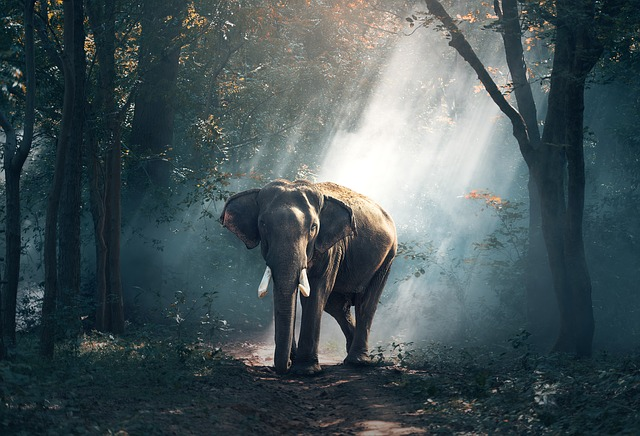

In [16]:
random_image_path = random.choice(image_path_list)
img = Image.open(random_image_path)
img

In [12]:
print(f"Image path: {random_image_path}")
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")
print(f"Image class: {random_image_path.parent.stem}")

Image path: data/raw-img/sheep/eb3cb30b21f0063ed1584d05fb1d4e9fe777ead218ac104497f5c978a6eab2b0_640.jpg
Image height: 426
Image width: 640
Image class: sheep


## Preparing Data

In [13]:
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

### Preparing Transformations

In [37]:
train_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(10),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        transforms.RandomResizedCrop(size=(224, 224), scale=(0.8, 1.0)),
        transforms.RandomAffine(degrees=10, translate=(0.1, 0.1)),
        transforms.ToTensor(),
        transforms.Lambda(lambda img: img + 0.02 * torch.randn_like(img)), # Noise injection
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

grayscale_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3)
])

test_transform = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.ToTensor()
])

train_transform, test_transform

(Compose(
     Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
     RandomHorizontalFlip(p=0.5)
     RandomRotation(degrees=[-10.0, 10.0], interpolation=nearest, expand=False, fill=0)
     ColorJitter(brightness=(0.8, 1.2), contrast=(0.8, 1.2), saturation=(0.8, 1.2), hue=(-0.1, 0.1))
     RandomResizedCrop(size=(224, 224), scale=(0.8, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear, antialias=True)
     RandomAffine(degrees=[-10.0, 10.0], translate=(0.1, 0.1))
     ToTensor()
     Lambda()
     Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
 ),
 Compose(
     Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
     ToTensor()
 ))

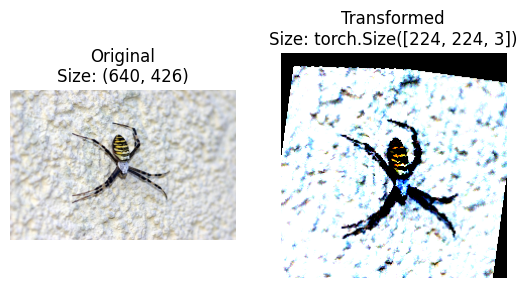

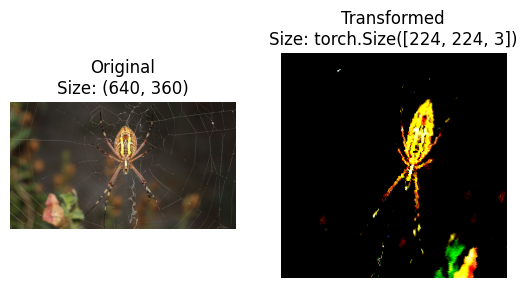

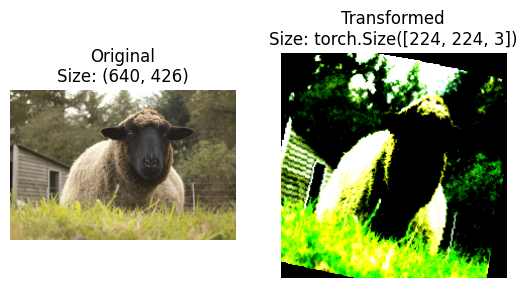

In [38]:
def plot_transformed_images(image_paths, transform, n=3, seed=42):

  if seed:
    random.seed(seed)
  random_image_paths = random.sample(image_paths, k=n)

  for image_path in random_image_paths:
    with Image.open(image_path) as f:
      fig, ax = plt.subplots(nrows=1, ncols=2)
      ax[0].imshow(f)
      ax[0].set_title(f"Original\nSize: {f.size}")
      ax[0].axis(False)

      transformed_image = transform(f).permute(1, 2, 0)
      ax[1].imshow(transformed_image)
      ax[1].set_title(f"Transformed\nSize: {transformed_image.shape}")
      ax[1].axis(False)

plot_transformed_images(image_path_list, train_transform)

### Preparing Image Folder, DataLoaders and Datasets

In [40]:
import os
from torch.utils.data import DataLoader
from project_modules.data_setup import create_dataloaders

BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

train_dataloader, test_dataloader, class_names = create_dataloaders(
    train_dir,
    test_dir,
    train_transform,
    test_transform,
    BATCH_SIZE,
    NUM_WORKERS
    )